In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib ipympl
import rowan
import numpy as np
from scipy.spatial.transform import Rotation as R
import math
import statistics


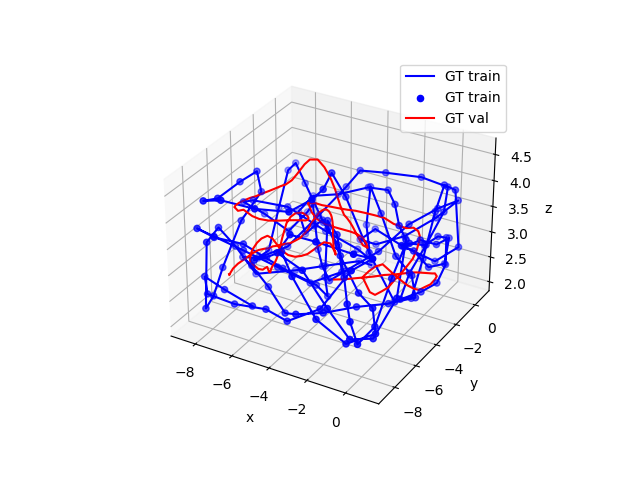

In [2]:
train_data = pd.read_csv(f'D:/Imperial/FYP/captured_data/airsim_drone_mode/train/airsim_rec_0.txt', sep="\t")
# train_data = train_data.iloc[::2, :]
val_data = pd.read_csv(f'D:/Imperial/FYP/captured_data/airsim_drone_mode/val/airsim_rec_0.txt', sep="\t")

plt.figure()
ax = plt.axes(projection= '3d')
ax.plot3D(train_data["POS_X"], train_data["POS_Y"], -train_data["POS_Z"], label = "GT train", color = 'blue')
ax.scatter(train_data["POS_X"], train_data["POS_Y"], -train_data["POS_Z"], label = "GT train", color = 'blue')
ax.plot3D(val_data["POS_X"], val_data["POS_Y"], -val_data["POS_Z"], label = "GT val", color = 'red')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.legend()
plt.show()

In [28]:
train_data["timestamp"] = pd.to_datetime(train_data["timestamp"], unit='ns')
train_data["seconds"] = (train_data["timestamp"] - train_data["timestamp"][0]).dt.total_seconds()
train_data["incremental_seconds"] = (train_data["seconds"] - train_data["seconds"].shift(1))
train_data["incremental_seconds"].fillna(0, inplace=True)
mean = statistics.mean(train_data["incremental_seconds"])
print(f"Average seconds between frames {mean}")

Average seconds between frames 1.8607201920000003


In [29]:
train_data["prev_Q_W"] = train_data["Q_W"].shift(1)
train_data["prev_Q_X"] = train_data["Q_X"].shift(1)
train_data["prev_Q_Y"] = train_data["Q_Y"].shift(1)
train_data["prev_Q_Z"] = train_data["Q_Z"].shift(1)
train_data["prev_POS_X"] = train_data["POS_X"].shift(1)
train_data["prev_POS_Y"] = train_data["POS_Y"].shift(1)
train_data["prev_POS_Z"] = train_data["POS_Z"].shift(1)

In [30]:
def euclidean_dist(prev_x, cur_x, prev_y, cur_y, prev_z, cur_z):
    return math.sqrt((prev_x - cur_x)**2 + (prev_y - cur_y)**2 + (prev_z - cur_z)**2)
train_data["distance_travelled"] = train_data.apply(lambda row: euclidean_dist(row["prev_POS_X"],row["prev_POS_Y"], row["prev_POS_Z"], row["POS_X"], row["POS_Y"], row["POS_Z"]), axis = 1)
train_data["distance_travelled"].head()

0         NaN
2    5.413227
4    7.411432
6    8.016558
8    7.802226
Name: distance_travelled, dtype: float64

## Acceleration

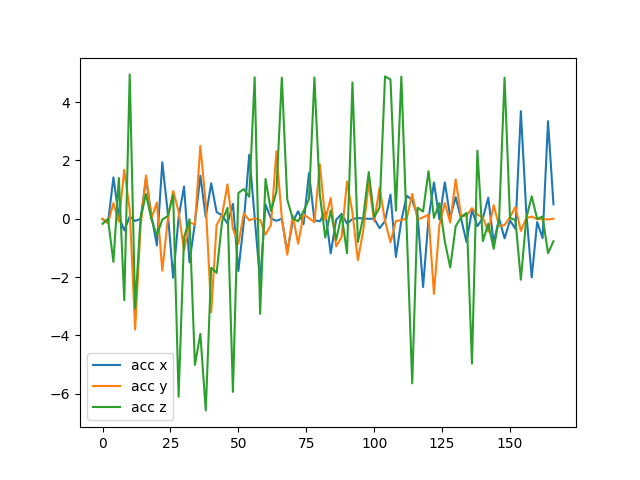

In [31]:
plt.figure()
train_data["LIN_ACC_X"].plot()
train_data["LIN_ACC_Y"].plot()
train_data["LIN_ACC_Z"].plot()
plt.legend(["acc x", "acc y", "acc z"])
plt.show()

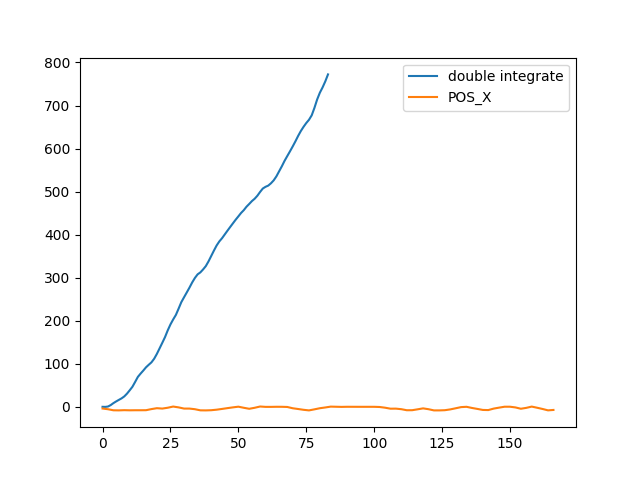

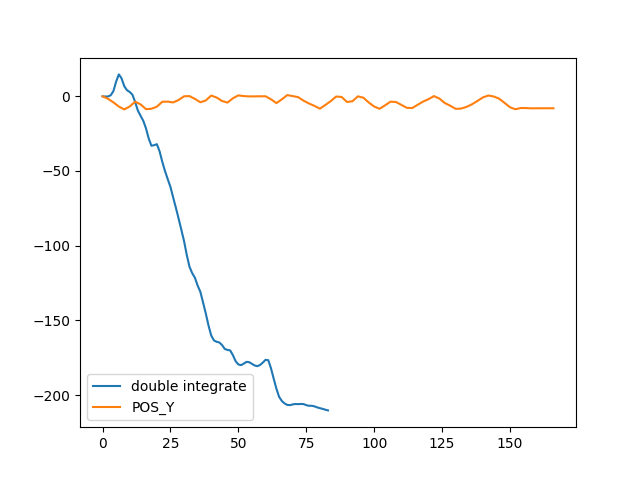

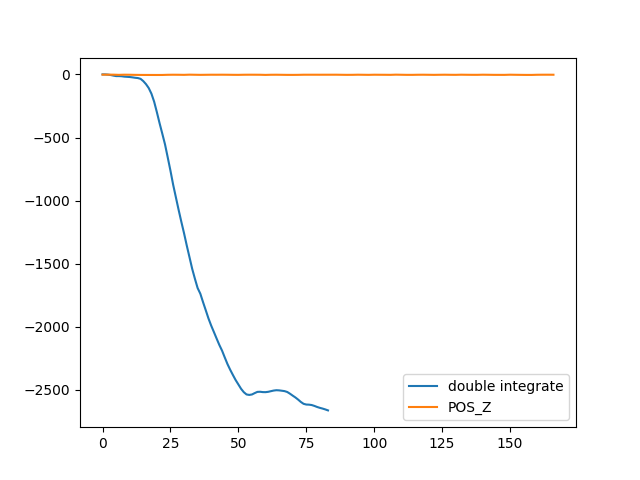

In [32]:
from scipy import integrate
t = train_data["seconds"]
velocity = integrate.cumtrapz(train_data["LIN_ACC_X"], t, initial=0)
displacement = integrate.cumtrapz(velocity, t, initial=0)

plt.figure()
plt.plot(displacement, label = "double integrate")
plt.plot(train_data["POS_X"], label = "POS_X")
plt.legend()

plt.figure()
velocity = integrate.cumtrapz(train_data["LIN_ACC_Y"], t, initial=0)
displacement = integrate.cumtrapz(velocity, t, initial=0)

plt.plot(displacement, label = "double integrate")
plt.plot(train_data["POS_Y"], label = "POS_Y")
plt.legend()

plt.figure()
velocity = integrate.cumtrapz(train_data["LIN_ACC_Z"], t, initial=0)
displacement = integrate.cumtrapz(velocity, t, initial=0)

plt.plot(displacement, label = "double integrate")
plt.plot(train_data["POS_Z"], label = "POS_Z")
plt.legend()

In [33]:
train_data["prev_LIN_VEL_X"] = train_data["LIN_VEL_X"].shift(1)
train_data["prev_LIN_VEL_Y"] = train_data["LIN_VEL_Y"].shift(1)
train_data["prev_LIN_VEL_Z"] = train_data["LIN_VEL_Z"].shift(1)
train_data["prev_LIN_ACC_X"] = train_data["LIN_ACC_X"].shift(1)
train_data["prev_LIN_ACC_Y"] = train_data["LIN_ACC_Y"].shift(1)
train_data["prev_LIN_ACC_Z"] = train_data["LIN_ACC_Z"].shift(1)

In [34]:
def get_imu_pred_pose(prev_location, initial_velocity, cur_accel, timestep):
    return prev_location + initial_velocity * timestep + 1/2 * cur_accel * timestep**2
train_data["imu_pred_POS_X"] = train_data.apply(lambda row : get_imu_pred_pose(row["prev_POS_X"], row["prev_LIN_VEL_X"], row["prev_LIN_ACC_X"], row["incremental_seconds"]), axis=1)
train_data["imu_pred_POS_Y"] = train_data.apply(lambda row : get_imu_pred_pose(row["prev_POS_Y"], row["prev_LIN_VEL_Y"], row["prev_LIN_ACC_Y"], row["incremental_seconds"]), axis=1)
train_data["imu_pred_POS_Z"] = train_data.apply(lambda row : get_imu_pred_pose(row["prev_POS_Z"], row["prev_LIN_VEL_Z"], row["prev_LIN_ACC_Z"], row["incremental_seconds"]), axis=1)

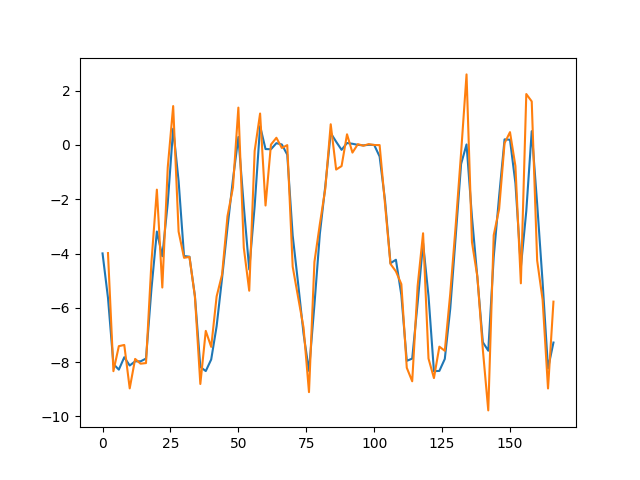

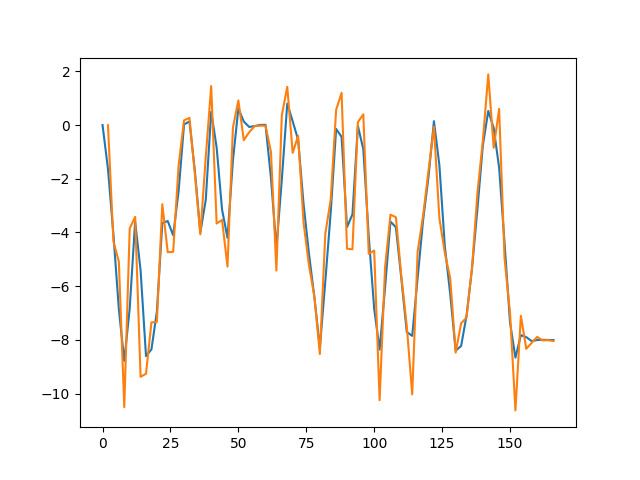

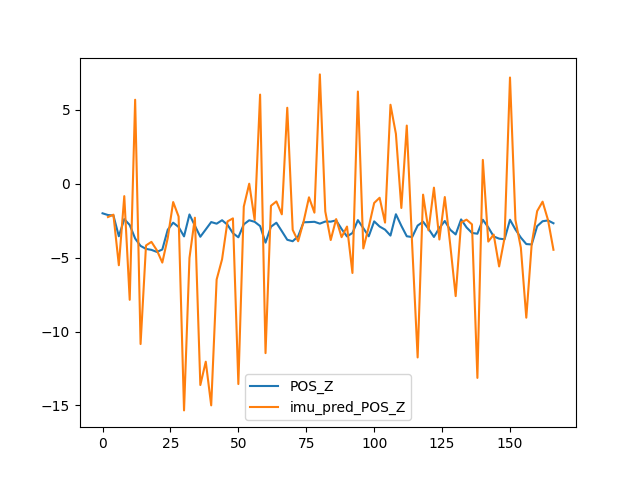

In [35]:
plt.figure()
train_data["POS_X"].plot()
train_data["imu_pred_POS_X"].plot()

plt.figure()
train_data["POS_Y"].plot()
train_data["imu_pred_POS_Y"].plot()

plt.figure()
train_data["POS_Z"].plot()
train_data["imu_pred_POS_Z"].plot()
plt.legend()

## Angular Velocity

In [ ]:
train_data.fillna(0, inplace =True)
train_data.head()

In [ ]:
def integrate_angular_velocity(row):
	return rowan.calculus.integrate(np.hstack([row["prev_Q_W"], row["prev_Q_X"], row["prev_Q_Y"], row["prev_Q_Z"]]), 
							 np.hstack([row["ANG_VEL_X"],row["ANG_VEL_Y"], row["ANG_VEL_Z"]]), row["incremental_seconds"])

train_data["pred_Q_W"] = train_data.iloc[1:,:].apply(lambda row: integrate_angular_velocity(row)[0], axis=1)
train_data["pred_Q_X"] = train_data.iloc[1:,:].apply(lambda row: integrate_angular_velocity(row)[1], axis=1)
train_data["pred_Q_Y"] = train_data.iloc[1:,:].apply(lambda row: integrate_angular_velocity(row)[2], axis=1)
train_data["pred_Q_Z"] = train_data.iloc[1:,:].apply(lambda row: integrate_angular_velocity(row)[3], axis=1)

In [ ]:
def convert_quat_to_euler(row, pred=False):
	if pred:
		r = R.from_quat(np.hstack([row["pred_Q_X"], row["pred_Q_Y"], row["pred_Q_Z"], row["pred_Q_W"]]))
	else:
		r = R.from_quat(np.hstack([row["Q_X"], row["Q_Y"], row["Q_Z"], row["Q_W"]]))
	return r.as_euler('xyz', degrees = True) #extrinsic rotation (Fixed frame)

train_data["roll"] = train_data.apply(lambda row: convert_quat_to_euler(row)[0], axis=1)
train_data["pitch"] =train_data.apply(lambda row: convert_quat_to_euler(row)[1], axis=1) 
train_data["yaw"] = train_data.apply(lambda row: convert_quat_to_euler(row)[2], axis=1)
train_data["pred_roll"] = train_data.iloc[1:,:].apply(lambda row: convert_quat_to_euler(row, True)[0], axis=1)
train_data["pred_pitch"] =train_data.iloc[1:,:].apply(lambda row: convert_quat_to_euler(row, True)[1], axis=1) 
train_data["pred_yaw"] = train_data.iloc[1:,:].apply(lambda row: convert_quat_to_euler(row, True)[2], axis=1)

plt.figure()
train_data["roll"].plot()
train_data["pitch"].plot()
train_data["yaw"].plot()
plt.legend(["roll", "pitch", "yaw"])

plt.figure()
train_data["pred_roll"].plot()
train_data["pred_pitch"].plot()
train_data["pred_yaw"].plot()
plt.legend(["roll", "pitch", "yaw"])

## Handling IMU

In [ ]:
plt.figure()
train_data["LIN_ACC_X"].plot()
train_data["LIN_ACC_Y"].plot()
train_data["LIN_ACC_Z"].plot()
plt.legend(["acc x", "acc y", "acc z"])
plt.show()

In [ ]:
plt.figure()
train_data.iloc[:-1,:]["S_LIN_ACC_X"].astype(float).plot()
train_data.iloc[:-1,:]["S_LIN_ACC_Y"].astype(float).plot()
train_data.iloc[:-1,:]["S_LIN_ACC_Z"].astype(float).plot()
plt.legend(["acc x", "acc y", "acc z"])
plt.show()

In [ ]:
def convert_body_to_world(row):
	body_acc = np.hstack([row["S_LIN_ACC_X"], row["S_LIN_ACC_Y"], row["S_LIN_ACC_Z"]]).astype(float)
	r = R.from_quat(np.hstack([row["Q_X"], row["Q_Y"], row["Q_Z"], row["Q_W"]]))
	world_acc = r.apply(body_acc)
	return world_acc - np.array([0, 0, -9.81])
train_data["S_LIN_ACC_X_world"] = train_data.iloc[:-1,:].apply(lambda row : convert_body_to_world(row)[0], axis = 1)
train_data["S_LIN_ACC_Y_world"] = train_data.iloc[:-1,:].apply(lambda row : convert_body_to_world(row)[1], axis = 1)
train_data["S_LIN_ACC_Z_world"] = train_data.iloc[:-1,:].apply(lambda row : convert_body_to_world(row)[2], axis = 1)

In [ ]:
plt.figure()
train_data.iloc[:-1,:]["S_LIN_ACC_X_world"].astype(float).plot()
train_data.iloc[:-1,:]["S_LIN_ACC_Y_world"].astype(float).plot()
train_data.iloc[:-1,:]["S_LIN_ACC_Z_world"].astype(float).plot()
train_data["LIN_ACC_X"].plot()
train_data["LIN_ACC_Y"].plot()
train_data["LIN_ACC_Z"].plot()
plt.legend(["acc x_S", "acc y_S", "acc z_S", "acc x", "acc y", "acc z"])
plt.show()